In [1]:
import eli5
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
from fbprophet import Prophet

%matplotlib inline

df = pd.read_csv('./data/city_pairs_new.csv')
df.head()

,Month,AustralianPort,ForeignPort,Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
0,31048,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1
1,31048,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1
2,31048,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1
3,31048,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1
4,31048,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1


In [2]:
df.describe()

,Month,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Passengers_Total,Freight_Total_(tonnes),Mail_Total_(tonnes),Year,Month_num
count,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000,78666.000000
mean,36894.488051,4195.605675,148.450751,7.336412,4136.150217,133.937711,4.324380,8331.755892,282.388462,11.660792,2000.550556,6.510081
std,3445.716536,8003.062147,361.721435,24.156593,7886.000880,341.089889,13.783958,15817.454421,665.612147,34.316063,9.432336,3.467954
min,31048.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1985.000000,1.000000
25%,34121.000000,116.000000,0.000000,0.000000,117.000000,0.000000,0.000000,251.000000,0.410000,0.000000,1993.000000,3.000000
50%,36526.000000,1149.000000,11.108000,0.000000,1121.000000,11.711500,0.000000,2282.000000,33.834000,0.105000,2000.000000,7.000000
75%,39692.000000,4362.000000,115.485250,1.490750,4213.750000,101.532000,1.460000,8636.750000,236.108750,4.388000,2008.000000,10.000000
max,43466.000000,84314.000000,4252.698000,393.705000,83168.000000,4996.582000,382.229000,162036.000000,7198.998000,566.993000,2019.000000,12.000000


In [3]:
#normailize featrure names
df.columns = [x.lower() for x in df]
#swap month feature names
df.rename(columns={'month': 'month_num2', 'month_num': 'month'}, inplace=True)
#create a year month column
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(Day=1))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78666 entries, 0 to 78665
Data columns (total 16 columns):
month_num2                78666 non-null int64
australianport            78666 non-null object
foreignport               78666 non-null object
country                   78666 non-null object
passengers_in             78666 non-null int64
freight_in_(tonnes)       78666 non-null float64
mail_in_(tonnes)          78666 non-null float64
passengers_out            78666 non-null int64
freight_out_(tonnes)      78666 non-null float64
mail_out_(tonnes)         78666 non-null float64
passengers_total          78666 non-null int64
freight_total_(tonnes)    78666 non-null float64
mail_total_(tonnes)       78666 non-null float64
year                      78666 non-null int64
month                     78666 non-null int64
year_month                78666 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(6), object(3)
memory usage: 9.6+ MB


In [4]:
df.head()

,month_num2,australianport,foreignport,country,passengers_in,freight_in_(tonnes),mail_in_(tonnes),passengers_out,freight_out_(tonnes),mail_out_(tonnes),passengers_total,freight_total_(tonnes),mail_total_(tonnes),year,month,year_month
0,31048,Adelaide,Auckland,New Zealand,1513,42.167,0.311,985,18.704,0.924,2498,60.871,1.235,1985,1,1985-01-01
1,31048,Adelaide,Bahrain,Bahrain,12,0.000,0.000,5,0.033,0.000,17,0.033,0.000,1985,1,1985-01-01
2,31048,Adelaide,Bombay,India,7,0.000,0.000,5,0.000,0.000,12,0.000,0.000,1985,1,1985-01-01
3,31048,Adelaide,Frankfurt,Germany,115,0.009,0.000,171,0.000,0.248,286,0.009,0.248,1985,1,1985-01-01
4,31048,Adelaide,London,UK,1567,2.800,0.000,1472,10.618,2.487,3039,13.418,2.487,1985,1,1985-01-01


In [5]:
#aggregate data for analysis
year_ag = df.groupby(['year']).sum()
month_ag = df.groupby(['year_month']).sum()
year_ag.head()

,month_num2,passengers_in,freight_in_(tonnes),mail_in_(tonnes),passengers_out,freight_out_(tonnes),mail_out_(tonnes),passengers_total,freight_total_(tonnes),mail_total_(tonnes),month
year,,,,,,,,,,,
1985,60685474,2646731,118478.146,1191.120,2553642,112523.371,3342.745,5200373,231001.517,4533.865,12783
1986,70238195,2973834,106913.502,1161.627,2844603,141825.156,3789.193,5818437,248738.658,4950.820,14634
1987,72963841,3436278,120715.623,1505.070,3278154,167215.126,4474.162,6714432,287930.749,5979.232,14932
1988,76288039,3955119,145316.319,5382.005,3811663,163567.332,5954.801,7766782,308883.651,11336.806,15456
1989,77411219,4015692,179555.714,8726.375,3915411,168283.658,6731.833,7931103,347839.372,15458.208,15495


In [6]:
year_ag.drop(['month', 'month_num2'], axis = 1, inplace=True)

<h3>Let's plot the yearly and monthly aggregated volume of passengers in and out of Autralian airports.</h3>

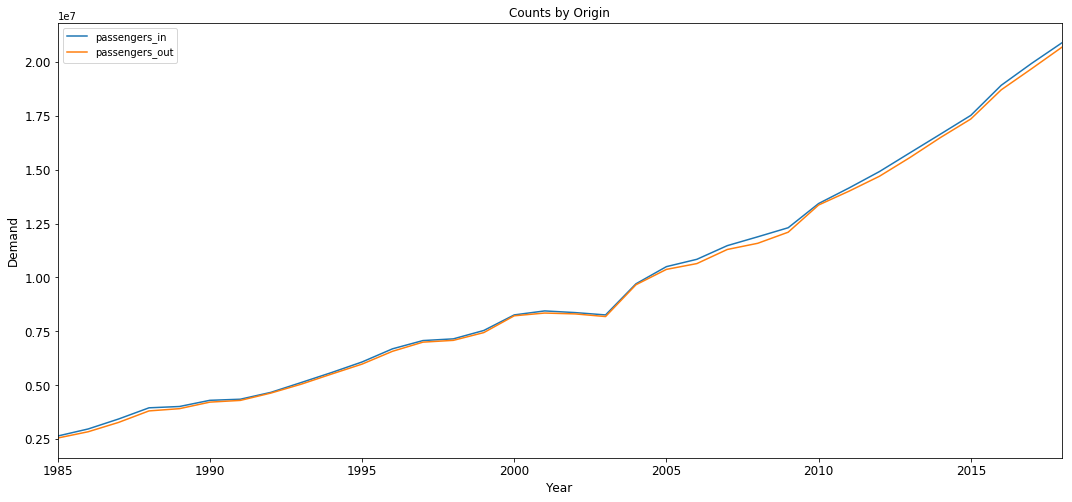

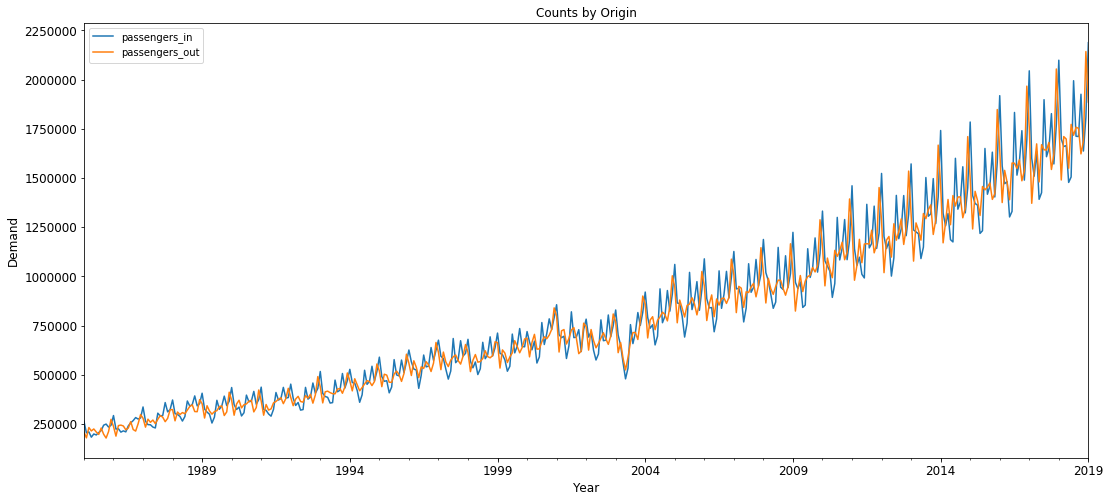

In [7]:
ax = year_ag[['passengers_in', 'passengers_out']].loc[year_ag.index<2019].plot(kind='line', title ="Counts by Origin", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.show()

ax = month_ag[['passengers_in', 'passengers_out']].plot(kind='line', title ="Counts by Origin", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.show()

<h3>We see a steady increase in demand over time. In the month plot we see some pretty obvious seasonality even at this extent.We will explore this further to confirm, but let's also check out some of the other features just for interests sake.</h3>

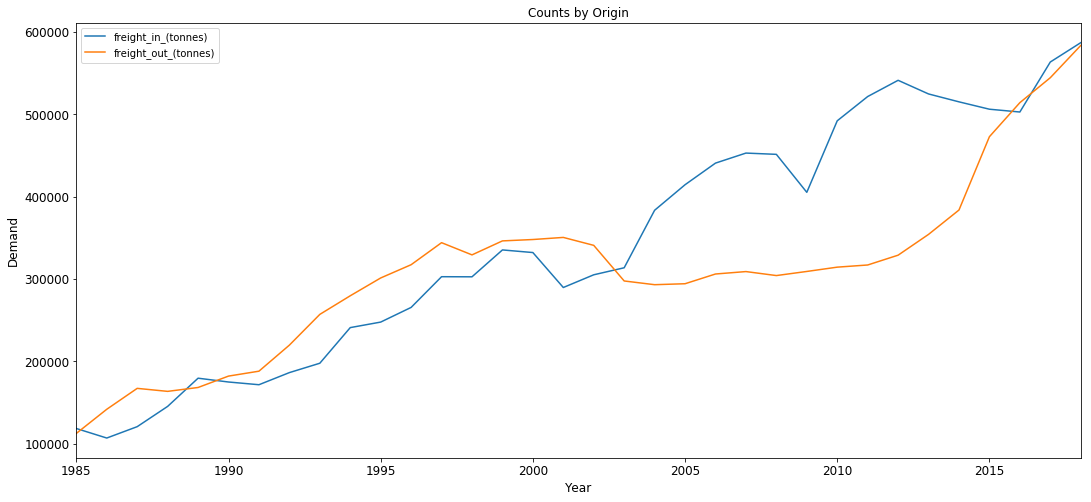

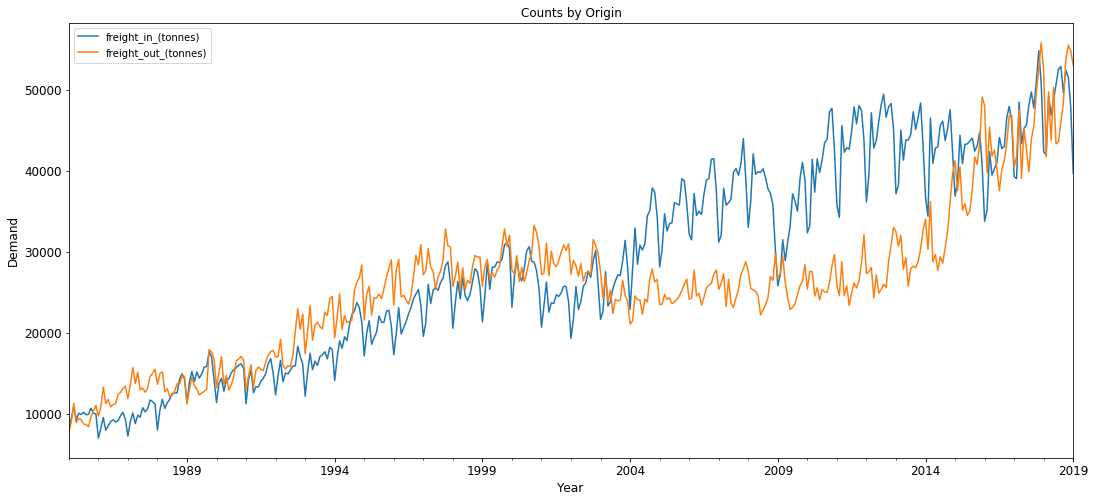

In [8]:
ax = year_ag[['freight_in_(tonnes)', 'freight_out_(tonnes)']].loc[year_ag.index<2019].plot(kind='line', title ="Counts by Origin", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.show()

ax = month_ag[['freight_in_(tonnes)', 'freight_out_(tonnes)']].plot(kind='line', title ="Counts by Origin", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.show()

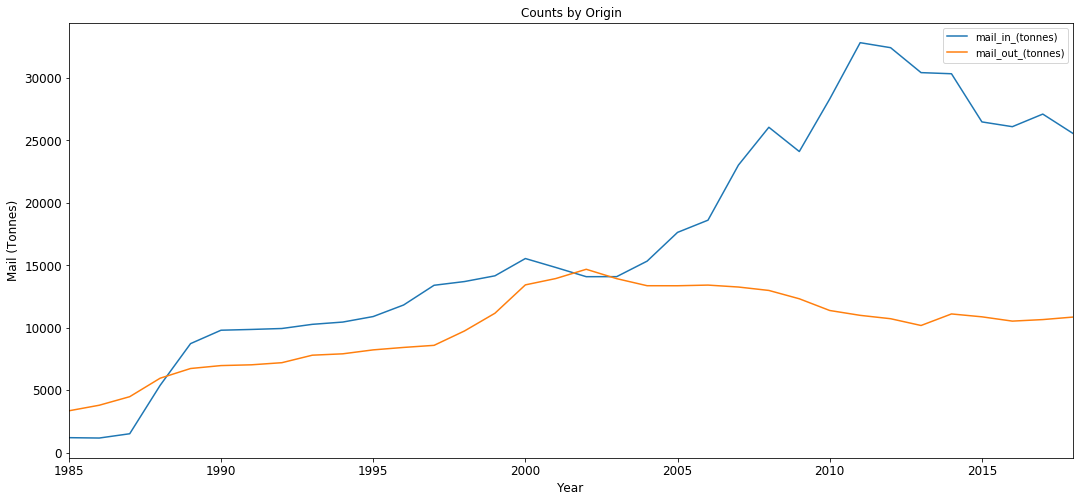

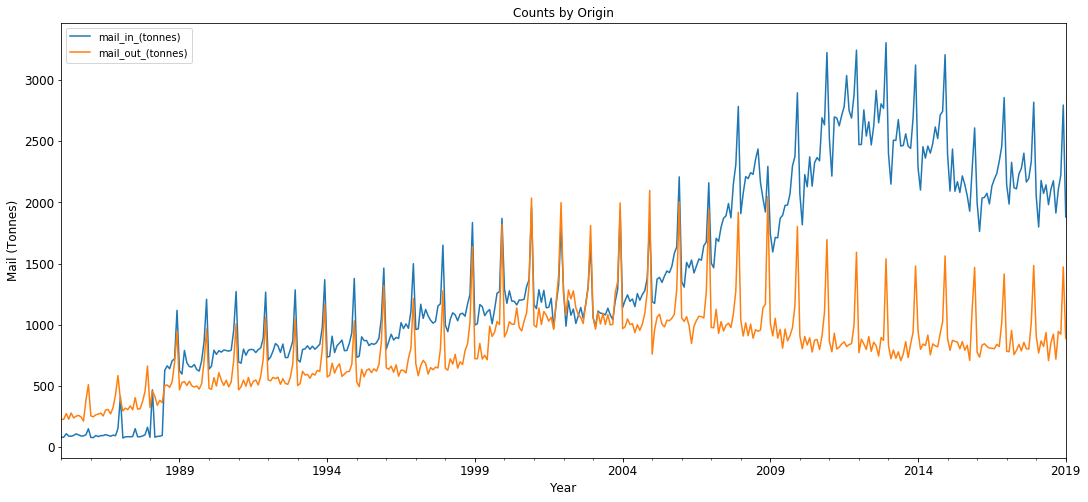

In [9]:
ax = year_ag[['mail_in_(tonnes)', 'mail_out_(tonnes)']].loc[year_ag.index<2019].plot(kind='line', title ="Counts by Origin", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Mail (Tonnes)", fontsize=12)
plt.show()

ax = month_ag[['mail_in_(tonnes)', 'mail_out_(tonnes)']].plot(kind='line', title ="Counts by Origin", figsize=(18, 8), legend=True, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Mail (Tonnes)", fontsize=12)
plt.show()

<h3>
<p>We see some pretty interesting trends in some of this data, but for the sake of this investigation we won't dive any deeper into these and just focus on passengers_out which we will refer to as flight demand.</p> 
<p>Now let's dig deeper into the possibility of seasonality in flight demand data. To do this we will start off by breaking down our time series data into systematic and unsystematic components.</p>
<p>
The systematic components of the time series are components that reoccur or have some variation of consistency that can be modeled. The non-systematic components are those that cannot be directly modeled.</p>
<p>    
A usual time series dataset in theory should commonly have three predominant components which are; <br />
    level - average in series.<br />
    trend - are the values in the series going up or down.<br /> 
    seasonality - cyclic or repeating trends in the data. <br />
</p>
<p>    
There are other components like noise which is observed random variation that is non-systematic.
We will use a self proclaimed nieve approach to investigate this, statsmodels seasonal decomposition, which states;
"This is a nieve decomposition. More sophisticated methods should be preferred.". This seasonal decomposition uses moving averages.</p>
<p>
The additive model is: Y[t] = T[t] + S[t] + e[t]<br />
The multiplicative model is: Y[t] = T[t] * S[t] * e[t]
   </p>
<p>Given more time on this I'd probably look at other decomposition methods (like Fourier) to confirm and identify any other interactions that this method is failing to find.<p></h3>

<Figure size 432x288 with 0 Axes>

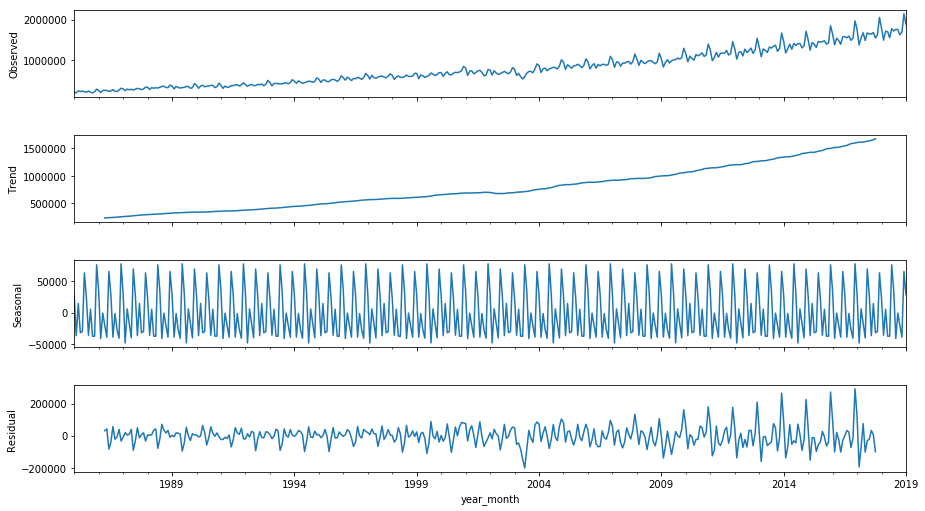

In [10]:
decomposition = seasonal_decompose(month_ag['passengers_out'], model='additive', freq=30)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

<h3>We see the trend in the data is a steady increase which is to be expected and is pretty universal in the airline industry for various reasons, more efficient technology, gas prices etc. We also see some pretty distinct seasonality which is to be expected. Now let's dig a little more into our data.</h3>

In [11]:
df.australianport.value_counts()

Sydney                    21539
Melbourne                 15516
Brisbane                  12991
Perth                      8592
Cairns                     6609
Adelaide                   5804
Darwin                     4328
Gold Coast                  871
Townsville                  660
Gold Coast/Coolangatta      503
Norfolk Island              412
Hobart                      314
Port Hedland                273
Christmas Island             80
Canberra                     64
Broome                       37
Sunshine Coast               33
Toowoomba Wellcamp           27
Newcastle                    13
Name: australianport, dtype: int64

In [12]:
df.foreignport.value_counts()

Auckland           3309
Singapore          3042
Denpasar           2869
Hong Kong          2600
Kuala Lumpur       2369
Tokyo              2304
Bangkok            2286
Christchurch       2155
London             1986
Los Angeles        1972
Jakarta            1839
Honolulu           1817
Frankfurt          1711
Port Moresby       1700
Wellington         1695
Manila             1672
Nadi               1608
Rome               1420
Vancouver          1385
Noumea             1251
Osaka              1199
Dubai              1177
Johannesburg       1133
Port Vila          1098
Taipei             1037
Nagoya             1022
San Francisco      1022
Bombay             1004
Seoul              1001
New York            972
                   ... 
Oshkosk               4
Abuja                 3
Fairbanks             3
Da Nang               3
Cape Town             3
Shimkent              2
Guiyang               2
Nanning               2
Jeju                  2
Victoria              2
Ankara          

In [13]:
df.country.value_counts()

New Zealand             9487
USA                     8177
Japan                   5372
Indonesia               5085
China                   3648
Singapore               3042
Thailand                2914
UK                      2783
Malaysia                2706
Canada                  2232
United Arab Emirates    2028
Papua New Guinea        1909
Philippines             1863
Fiji                    1849
Hong Kong               1736
Germany                 1711
Italy                   1447
New Caledonia           1251
Vanuatu                 1248
India                   1207
South Africa            1142
Vietnam                 1060
Taiwan                  1037
Korea                   1003
Brunei                   888
Hong Kong (SAR)          864
Tahiti                   831
Bahrain                  757
France                   750
Solomon Islands          714
                        ... 
Qatar                    278
Cook Islands             239
Sri Lanka                214
Oman          

In [14]:
country_year_ag = df.loc[df['year']<2019].groupby(['year','country']).sum()
country_year_ag.head()

month_num2  passengers_in  freight_in_(tonnes)  \
year country                                                   
1985 Bahrain     2528177           3575               13.116   
     Brunei       748542           3147                3.956   
     Canada      1498296          19228              518.838   
     China       1123722          12495              357.771   
     Cyprus       187014             57                0.000   

              mail_in_(tonnes)  passengers_out  freight_out_(tonnes)  \
year country                                                           
1985 Bahrain             6.922            2428              1108.267   
     Brunei              0.000            3455               483.855   
     Canada              0.000           19537               778.411   
     China               2.168           13018               140.537   
     Cyprus              0.000             129                 0.009   

              mail_out_(tonnes)  passengers_total  freight_total_(tonnes)  \
year country                                                                
1985 Bahrain             37.863              6003                1121.383   
     Brunei               0.000              6602                 487.811   
     Canada              39.348             38765                1297.249   
     China                0.109             25513                 498.308   
     Cyprus               0.000               186                   0.009   

              mail_total_(tonnes)  month  
year country                              
1985 Bahrain               44.785    520  
     Brunei                 0.000    136  
     Canada                39.348    312  
     China                  2.277    234  
     Cyprus                 0.000     30

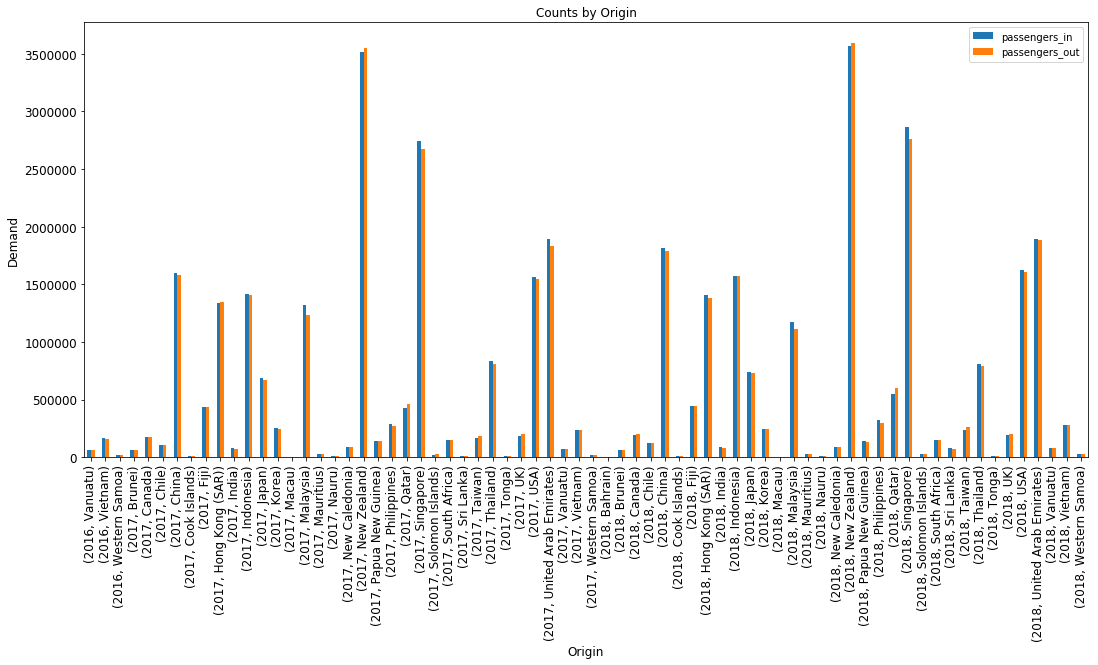

In [15]:
ax = country_year_ag[['passengers_in', 'passengers_out']][-70:].plot(kind='bar', title ="Counts by Origin", figsize=(18, 8), 
                                                       legend=True, fontsize=12)
ax.set_xlabel("Origin", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.show()

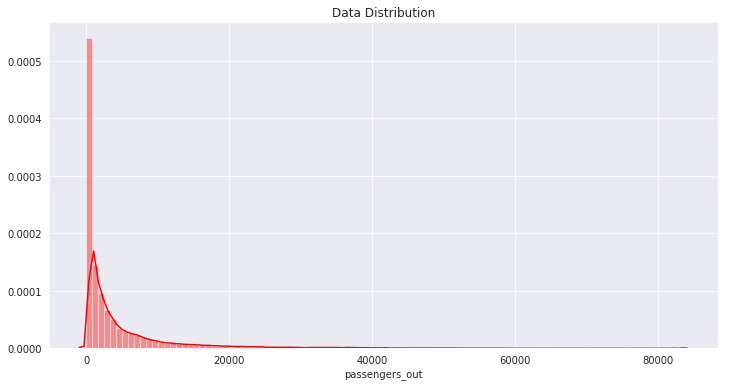

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.title('Data Distribution')
sns.distplot(df['passengers_out'], color="r", bins=100)
plt.show()

/home/srooney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


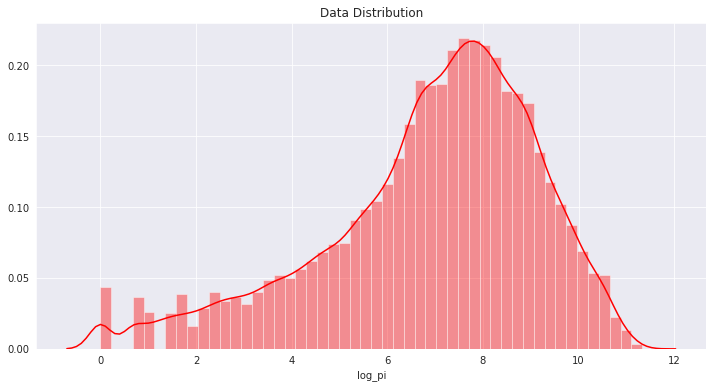

In [17]:
df['log_pi'] = np.log(df['passengers_out'])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["log_pi"], how="all")
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))
plt.title('Data Distribution')
sns.distplot(df['log_pi'], color="r")
plt.show()

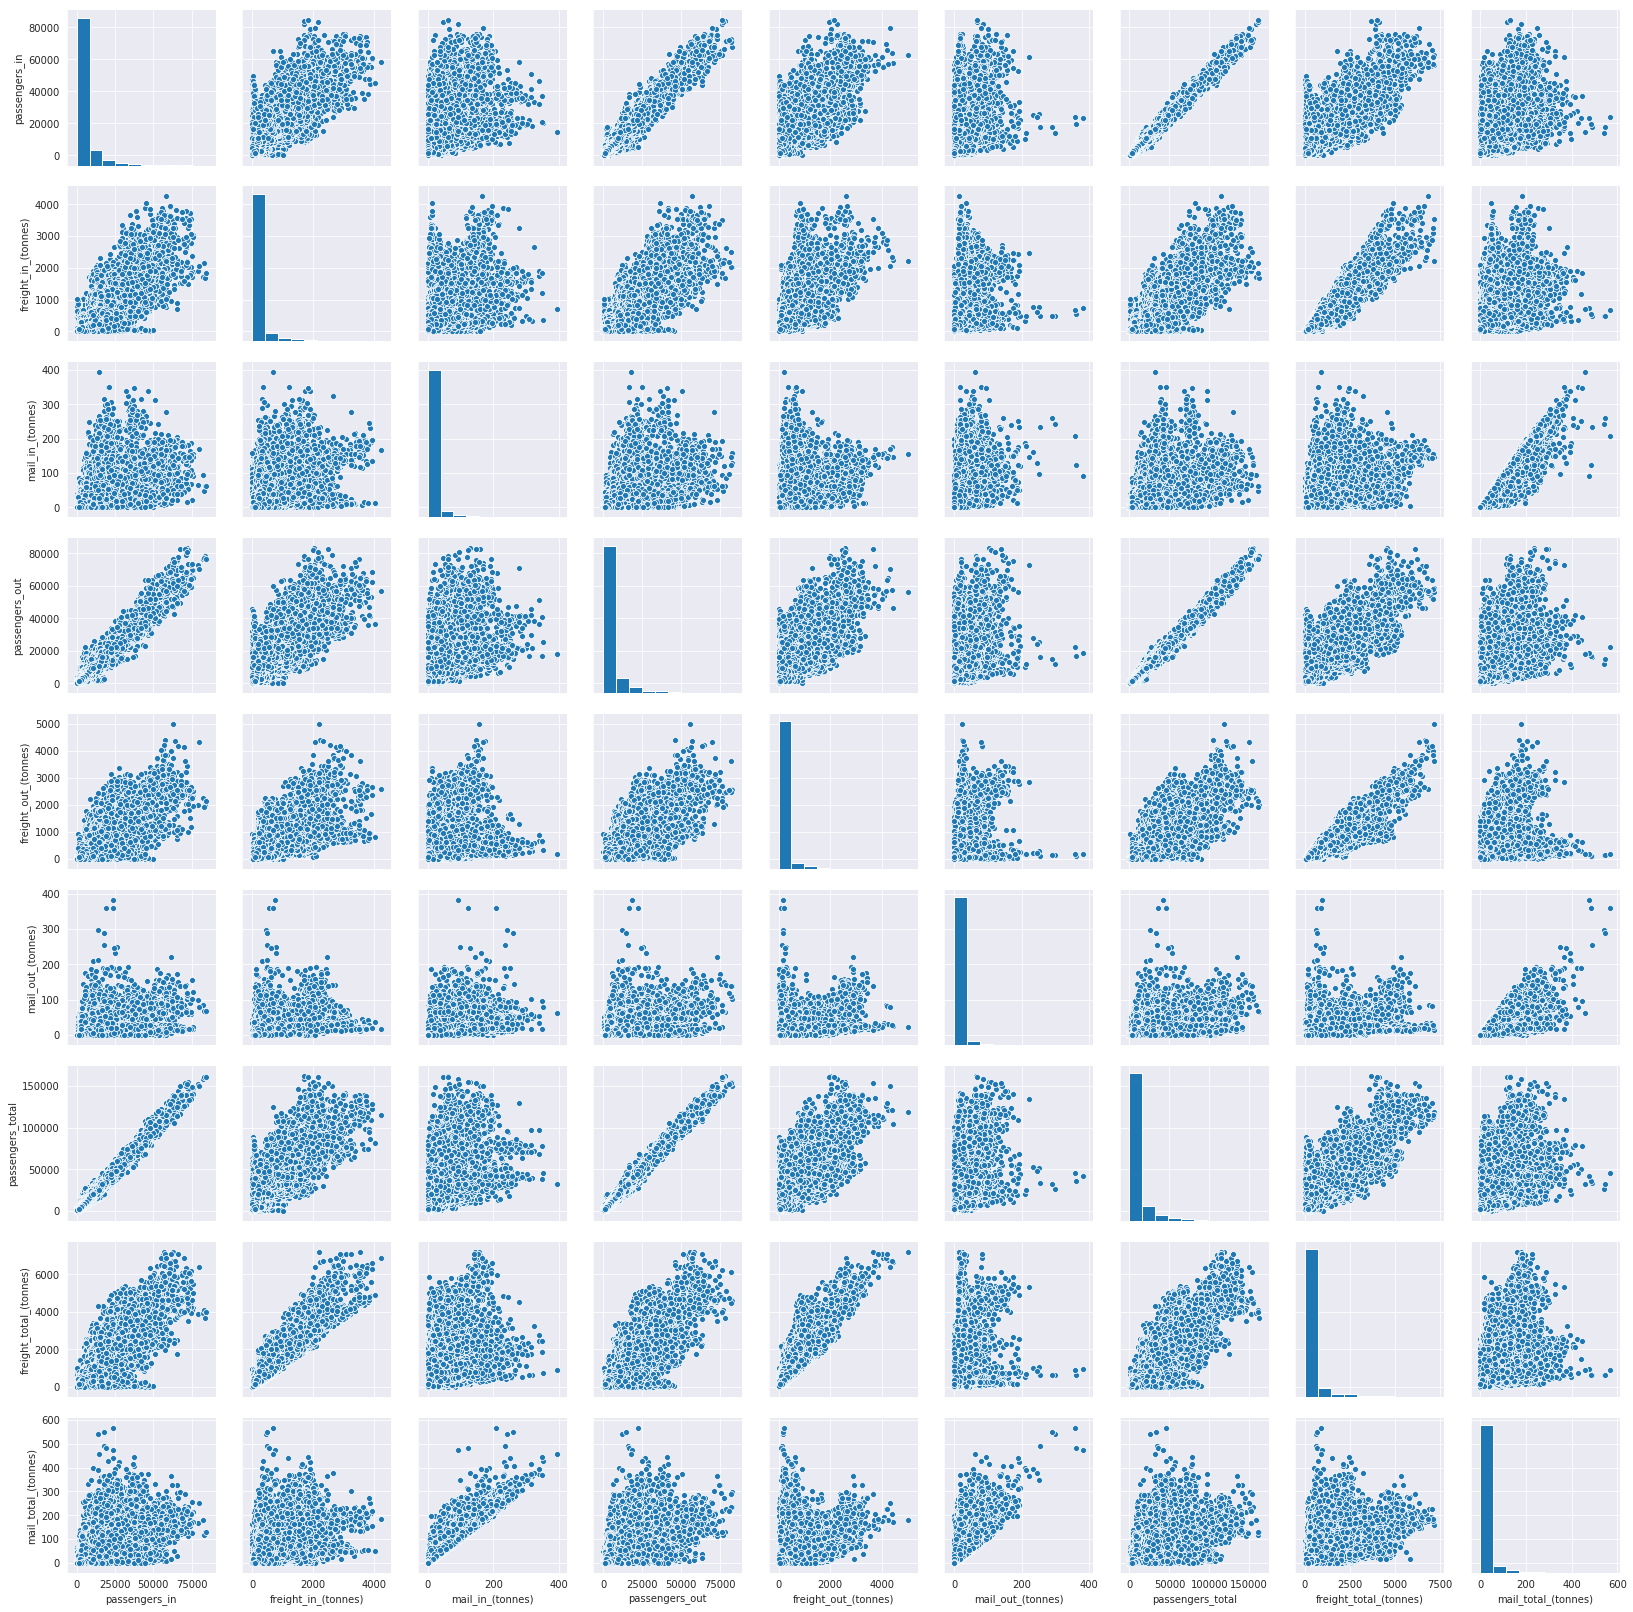

In [18]:
sns.pairplot(df[['passengers_in','freight_in_(tonnes)','mail_in_(tonnes)','passengers_out','freight_out_(tonnes)',
                 'mail_out_(tonnes)','passengers_total','freight_total_(tonnes)','mail_total_(tonnes)']])

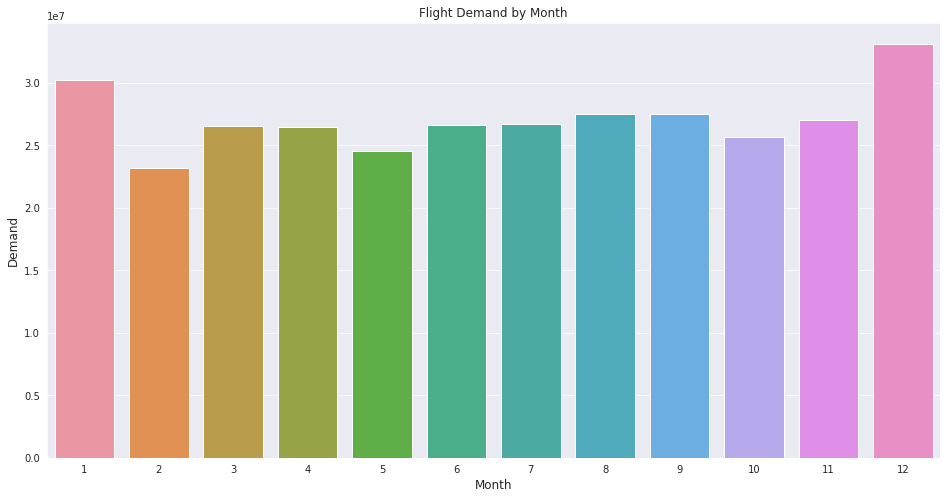

In [19]:
origin_totals = pd.DataFrame(df.groupby(['month']).sum()).reset_index()
plt.figure(figsize=(16,8))
ax = sns.barplot(x="month", y="passengers_out", data=origin_totals)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Demand", fontsize=12)
plt.title('Flight Demand by Month')
plt.show()

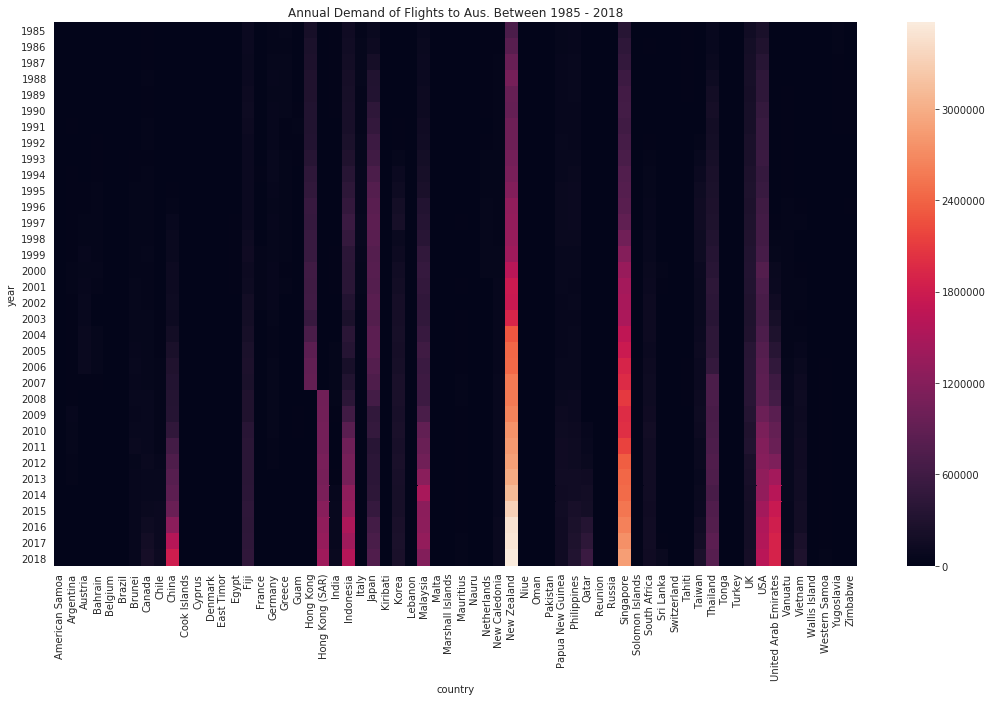

In [20]:
in_passengers_year = df[['year', 'country', 'passengers_in']].groupby(['year', 'country']).sum()
in_passengers_year = in_passengers_year.pivot_table(values='passengers_in', index='year', columns='country', fill_value=0)

plt.figure(figsize=(18,10))
ax = sns.heatmap(in_passengers_year.loc[in_passengers_year.index<2019])
ax.set_title('Annual Demand of Flights to Aus. Between 1985 - 2018')
plt.yticks(rotation=0)
plt.show()

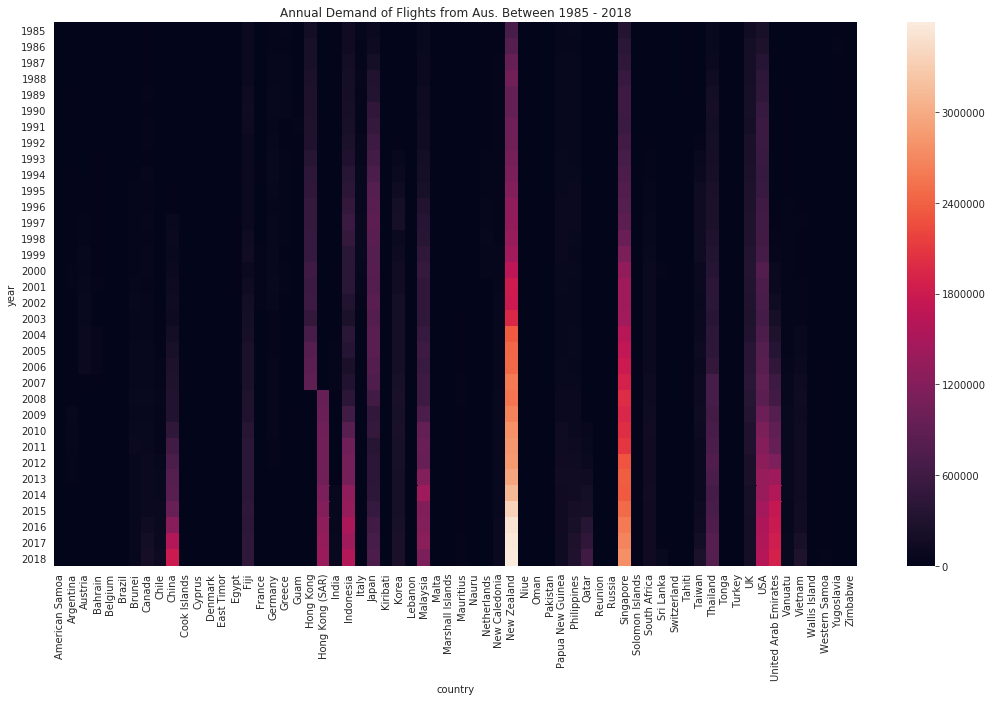

In [21]:
out_passengers_year = df[['year', 'country', 'passengers_out']].groupby(['year', 'country']).sum()
out_passengers_year = out_passengers_year.pivot_table(values='passengers_out', index='year', columns='country', fill_value=0)

plt.figure(figsize=(18,10))
ax = sns.heatmap(out_passengers_year.loc[out_passengers_year.index<2019])
ax.set_title('Annual Demand of Flights from Aus. Between 1985 - 2018')
plt.yticks(rotation=0)
plt.show()

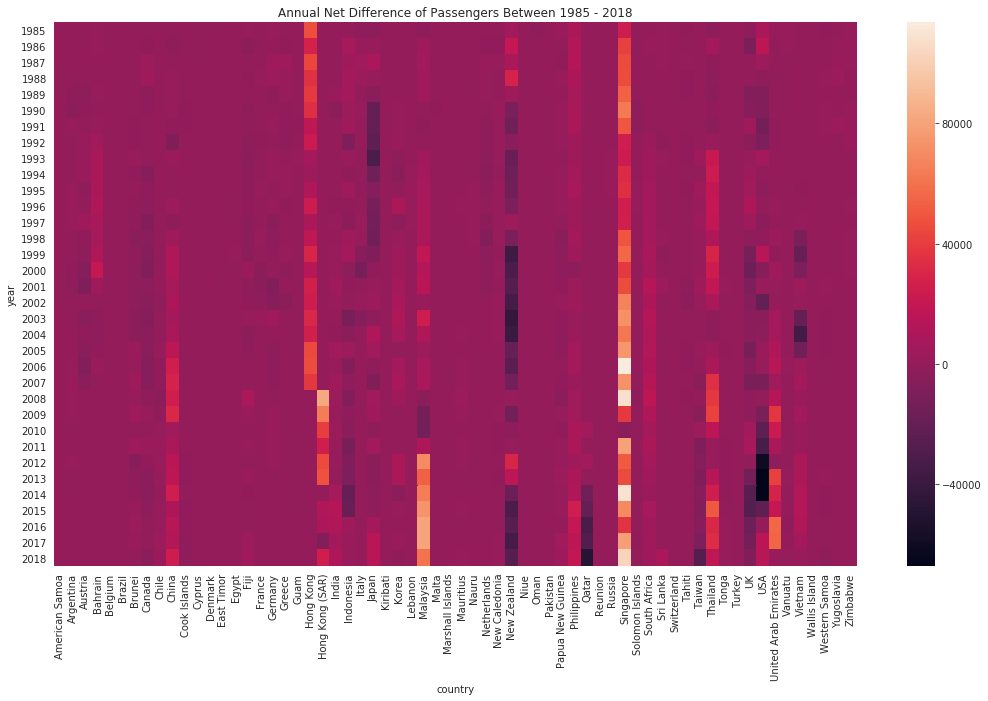

In [22]:
df['pass_diff'] = df['passengers_in'] - df['passengers_out']
out_passengers_year = df[['year', 'country', 'pass_diff']].groupby(['year', 'country']).sum()
out_passengers_year = out_passengers_year.pivot_table(values='pass_diff', index='year', columns='country', fill_value=0)

plt.figure(figsize=(18,10))
ax = sns.heatmap(out_passengers_year.loc[out_passengers_year.index<2019])
ax.set_title('Annual Net Difference of Passengers Between 1985 - 2018')
plt.yticks(rotation=0)
plt.show()

In [23]:
df['o_d'] = df['australianport']+'_'+df['foreignport']
#groupby search date and ori/dest
df2 = df[['year_month','o_d', 'passengers_out']].groupby(['year_month', 'o_d']).sum()

#Pivot our data, each ori/dest pair will now be a column in the df.
df3 = df2.pivot_table(values='passengers_out', index='year_month', columns='o_d', fill_value=0).reset_index()

#Aggregate by day and month.
by_month = df3.groupby(pd.Grouper(key='year_month', freq="M")).sum()
by_month.head()

o_d,Adelaide_Abu Dhabi,Adelaide_Amsterdam,Adelaide_Athens,Adelaide_Atlanta,Adelaide_Auckland,Adelaide_Bahrain,Adelaide_Bangkok,Adelaide_Beijing,Adelaide_Belgrade,Adelaide_Bombay,...,Townsville_Denpasar,Townsville_Frankfurt,Townsville_Kuala Lumpur,Townsville_London,Townsville_Manchester,Townsville_Port Moresby,Townsville_Rome,Townsville_Singapore,Townsville_Wellington,Townsville_Zagreb
year_month,,,,,,,,,,,,,,,,,,,,,
1985-01-31,0,0,0,0,985,5,0,0,0,5,...,0,36,0,121,0,0,19,341,0,0
1985-02-28,0,0,0,0,921,15,0,0,0,2,...,0,21,0,88,0,0,28,261,0,0
1985-03-31,0,0,0,0,1305,11,0,0,0,2,...,0,30,0,145,0,0,55,264,0,0
1985-04-30,0,0,0,0,725,9,0,0,0,4,...,0,56,0,91,0,0,46,374,0,0
1985-05-31,0,0,0,0,1116,11,0,0,0,1,...,0,69,0,145,0,0,47,276,0,0


In [24]:
by_month = by_month.reset_index()
by_month.head()

o_d,year_month,Adelaide_Abu Dhabi,Adelaide_Amsterdam,Adelaide_Athens,Adelaide_Atlanta,Adelaide_Auckland,Adelaide_Bahrain,Adelaide_Bangkok,Adelaide_Beijing,Adelaide_Belgrade,...,Townsville_Denpasar,Townsville_Frankfurt,Townsville_Kuala Lumpur,Townsville_London,Townsville_Manchester,Townsville_Port Moresby,Townsville_Rome,Townsville_Singapore,Townsville_Wellington,Townsville_Zagreb
0,1985-01-31,0,0,0,0,985,5,0,0,0,...,0,36,0,121,0,0,19,341,0,0
1,1985-02-28,0,0,0,0,921,15,0,0,0,...,0,21,0,88,0,0,28,261,0,0
2,1985-03-31,0,0,0,0,1305,11,0,0,0,...,0,30,0,145,0,0,55,264,0,0
3,1985-04-30,0,0,0,0,725,9,0,0,0,...,0,56,0,91,0,0,46,374,0,0
4,1985-05-31,0,0,0,0,1116,11,0,0,0,...,0,69,0,145,0,0,47,276,0,0


/home/srooney/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


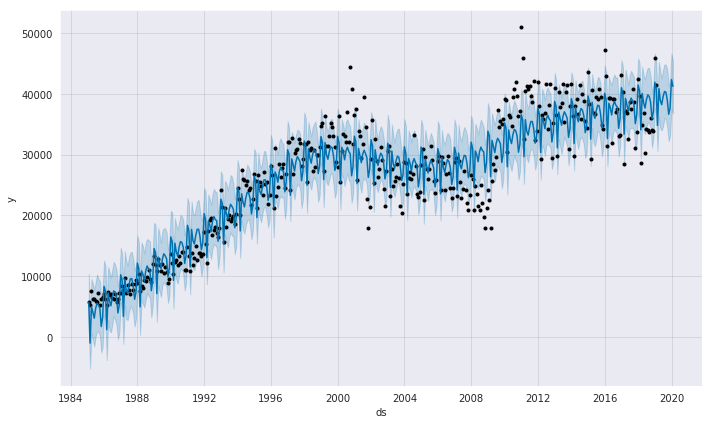

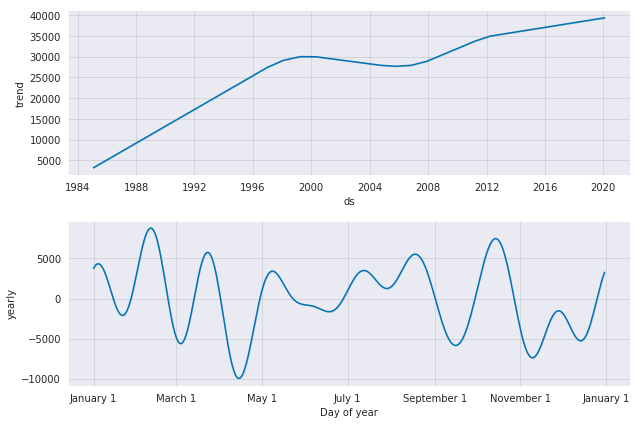

In [25]:
data = by_month[['year_month','Sydney_Los Angeles']]
data.head()

data.columns = ['ds', 'y']
data.head()

model = Prophet()
model.fit(data)

future_data = model.make_future_dataframe(periods=12, freq = 'm')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
model.plot(forecast_data);
model.plot_components(forecast_data);

In [26]:
X = df[['australianport', 'foreignport', 'year', 'month', 'passengers_out', 'year_month']]
X.head()

,australianport,foreignport,year,month,passengers_out,year_month
0,Adelaide,Auckland,1985,1,985,1985-01-01
1,Adelaide,Bahrain,1985,1,5,1985-01-01
2,Adelaide,Bombay,1985,1,5,1985-01-01
3,Adelaide,Frankfurt,1985,1,171,1985-01-01
4,Adelaide,London,1985,1,1472,1985-01-01


In [27]:
X = pd.get_dummies(X, columns=['australianport', 'foreignport'])#, 'year', 'month'
X.head()

,year,month,passengers_out,year_month,australianport_Adelaide,australianport_Brisbane,australianport_Broome,australianport_Cairns,australianport_Canberra,australianport_Christmas Island,...,foreignport_Vienna,foreignport_Wallis Island,foreignport_Washington,foreignport_Wellington,foreignport_Wuhan,foreignport_Xi'an,foreignport_Xiamen,foreignport_Zagreb,foreignport_Zhengzhou,foreignport_Zurich
0,1985,1,985,1985-01-01,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1985,1,5,1985-01-01,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1985,1,5,1985-01-01,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1985,1,171,1985-01-01,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1985,1,1472,1985-01-01,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
d = X
start = dt.datetime.strptime('2017-10-31', '%Y-%m-%d') #'2017-10-31'
X_train, X_test = d.loc[d['year_month'] <= start].drop(['year_month', 'passengers_out'], axis = 1), d.loc[d['year_month'] > start].drop(['year_month', 'passengers_out'], axis = 1)
y_train, y_test = d.loc[d['year_month'] <= start]['passengers_out'], d.loc[d['year_month'] > start]['passengers_out']

In [29]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [2, 10, 50, 100, 200],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 500, 1000, 1500, 2000]}

rf = RandomForestRegressor()
tfolds = TimeSeriesSplit(n_splits=3)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, 
                               cv = tfolds, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(f'Best model: {rf_random.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.5min finished


Best model: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 200, 'bootstrap': False}


In [30]:
rfr = rf_random.best_estimator_
rfr.fit(X_train, y_train)
print("Train-set R^2: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test-set R^2: {:.2f}".format(rfr.score(X_test, y_test)))
rf_y_pred = rfr.predict(X_test)
rf_y_pred_train = rfr.predict(X_train)

Train-set R^2: 1.00
Test-set R^2: 0.97


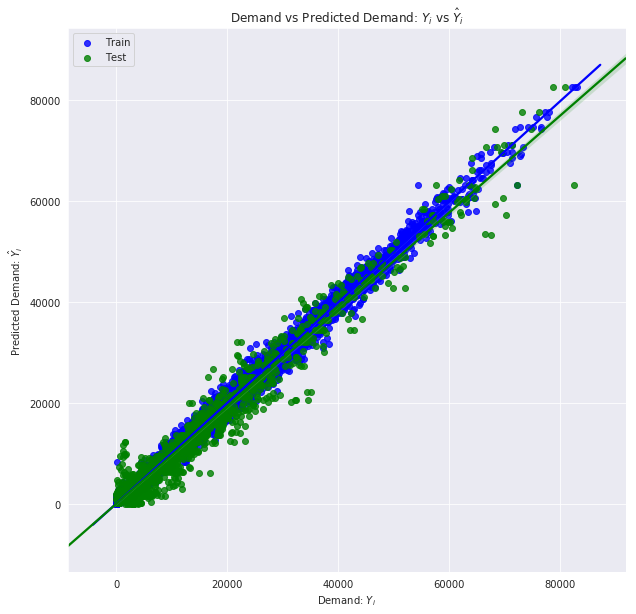

In [31]:
rf_viz_y_train = d.loc[d['year_month'] <= start][['year_month', 'passengers_out']]
rf_viz_y_test = d.loc[d['year_month'] > start][['year_month', 'passengers_out']]
rf_viz_y_train['y_pred'] = rf_y_pred_train
rf_viz_y_test['y_pred'] = rf_y_pred
rf_y_test_gbd = rf_viz_y_test.groupby('year_month').sum()
rf_y_train_gbd = rf_viz_y_train.groupby('year_month').sum()

plt.figure(figsize=(10, 10))
ax = sns.regplot(rf_viz_y_train['passengers_out'], rf_viz_y_train['y_pred'], label='Train', color="b")
ax = sns.regplot(rf_viz_y_test['passengers_out'], rf_viz_y_test['y_pred'], label='Test', color="g")
plt.xlabel("Demand: $Y_i$")
plt.ylabel("Predicted Demand: $\hat{Y}_i$")
plt.title("Demand vs Predicted Demand: $Y_i$ vs $\hat{Y}_i$")
plt.legend()
plt.show()

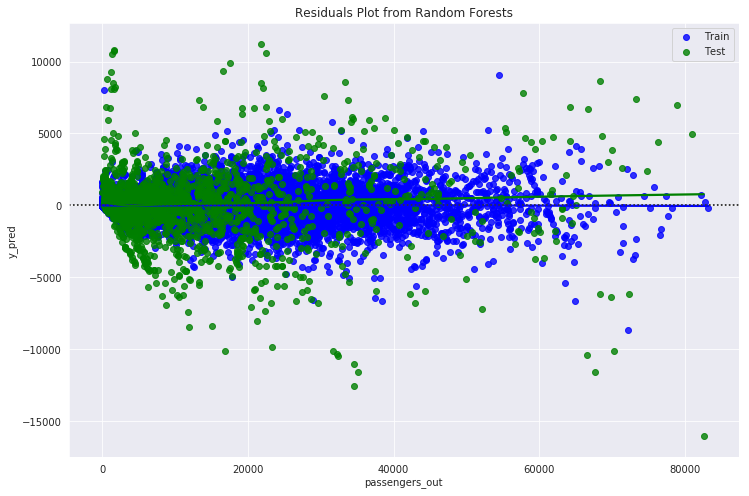

In [32]:
plt.figure(figsize=(12,8))
sns.residplot(rf_viz_y_train['passengers_out'], rf_viz_y_train['y_pred'], lowess=True, color="b", label='Train')
sns.residplot(rf_viz_y_test['passengers_out'], rf_viz_y_test['y_pred'], lowess=True, color="g", label='Test')
plt.title('Residuals Plot from Random Forests')
plt.legend()
plt.show()

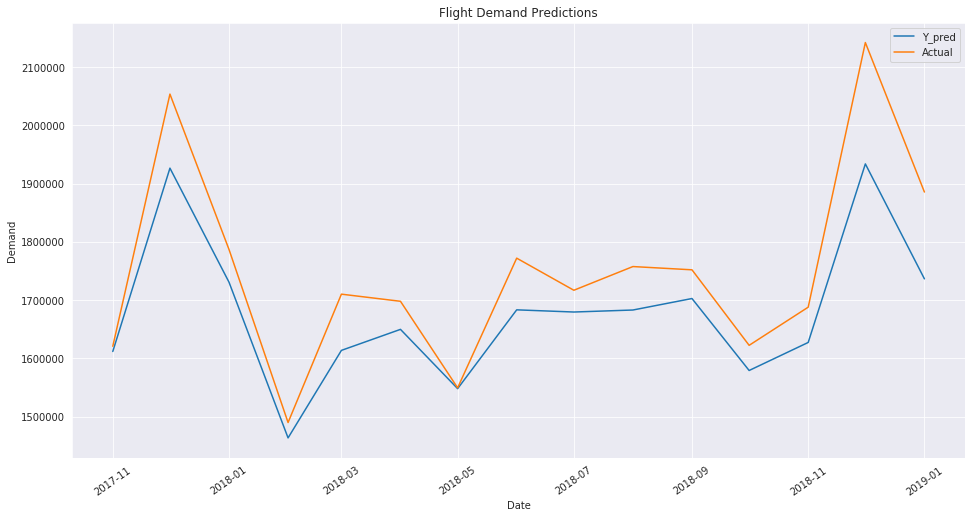

In [33]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,8))
plt.title('Flight Demand Predictions')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot(rf_y_test_gbd.index, rf_y_test_gbd['y_pred'], label='Y_pred')
plt.plot(rf_y_test_gbd.index, rf_y_test_gbd['passengers_out'], label='Actual')
plt.xticks(rotation=35)
plt.legend()
plt.show()

In [34]:
print('Test RMSE: ',((rf_y_test_gbd['y_pred'] - rf_y_test_gbd['passengers_out']) ** 2).mean() ** .5)

Test RMSE:  89521.19800314406


In [35]:
eli5.show_weights(rfr, feature_names=list(X_train))

Weight,Feature
0.2056 ± 0.0000,year
0.1768 ± 0.0000,australianport_Sydney
0.1064 ± 0.0000,foreignport_Singapore
0.0869 ± 0.0000,foreignport_Auckland
0.0816 ± 0.0003,australianport_Melbourne
0.0633 ± 0.0004,australianport_Brisbane
0.0475 ± 0.0001,australianport_Perth
0.0397 ± 0.0000,foreignport_Los Angeles
0.0255 ± 0.0000,foreignport_Hong Kong
0.0204 ± 0.0000,month


In [36]:
model = XGBRegressor()
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 2.5, 5],
        'subsample': [0.5, 1.0],
        'colsample_bytree': [0.5, 1.0],
        'max_depth': [3, 7, 12],
        'n_estimators':[5, 100, 250, 500]
        }
tfolds = TimeSeriesSplit(n_splits=3)
grid_search = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=tfolds, verbose=2, n_iter=10)
grid_result = grid_search.fit(X_train, y_train)
print(f'Best model: {grid_result.best_params_}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.5min remaining:   26.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


Best model: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 5, 'colsample_bytree': 1.0}


Train-set R^2: 0.99
Test-set R^2: 0.96


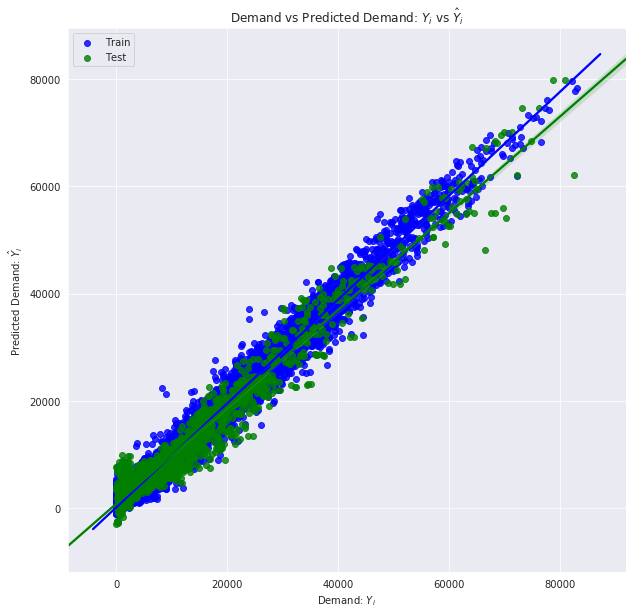

In [37]:
xg = grid_result.best_estimator_
xg.fit(X_train, y_train)
print("Train-set R^2: {:.2f}".format(xg.score(X_train, y_train)))
print("Test-set R^2: {:.2f}".format(xg.score(X_test, y_test)))
xg_y_pred = xg.predict(X_test)
xg_y_pred_train = xg.predict(X_train)

xg_viz_y_train = d.loc[d['year_month'] <= start][['year_month', 'passengers_out']]
xg_viz_y_test = d.loc[d['year_month'] > start][['year_month', 'passengers_out']]
xg_viz_y_train['y_pred'] = xg_y_pred_train
xg_viz_y_test['y_pred'] = xg_y_pred
xg_y_test_gbd = xg_viz_y_test.groupby('year_month').sum()
xg_y_train_gbd = xg_viz_y_train.groupby('year_month').sum()

plt.figure(figsize=(10, 10))
ax = sns.regplot(xg_viz_y_train['passengers_out'], xg_viz_y_train['y_pred'], label='Train', color="b")
ax = sns.regplot(xg_viz_y_test['passengers_out'], xg_viz_y_test['y_pred'], label='Test', color="g")
plt.xlabel("Demand: $Y_i$")
plt.ylabel("Predicted Demand: $\hat{Y}_i$")
plt.title("Demand vs Predicted Demand: $Y_i$ vs $\hat{Y}_i$")
plt.legend()
plt.show()

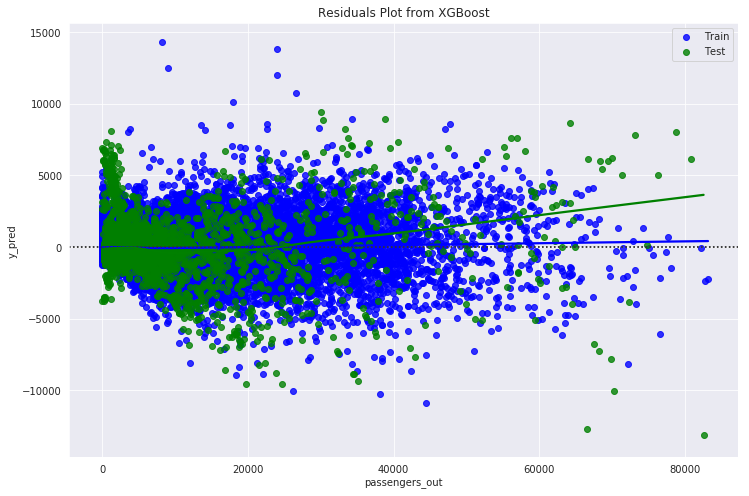

In [38]:
plt.figure(figsize=(12,8))
sns.residplot(xg_viz_y_train['passengers_out'], xg_viz_y_train['y_pred'], lowess=True, color="b", label='Train')
sns.residplot(xg_viz_y_test['passengers_out'], xg_viz_y_test['y_pred'], lowess=True, color="g", label='Test')
plt.title('Residuals Plot from XGBoost')
plt.legend()
plt.show()

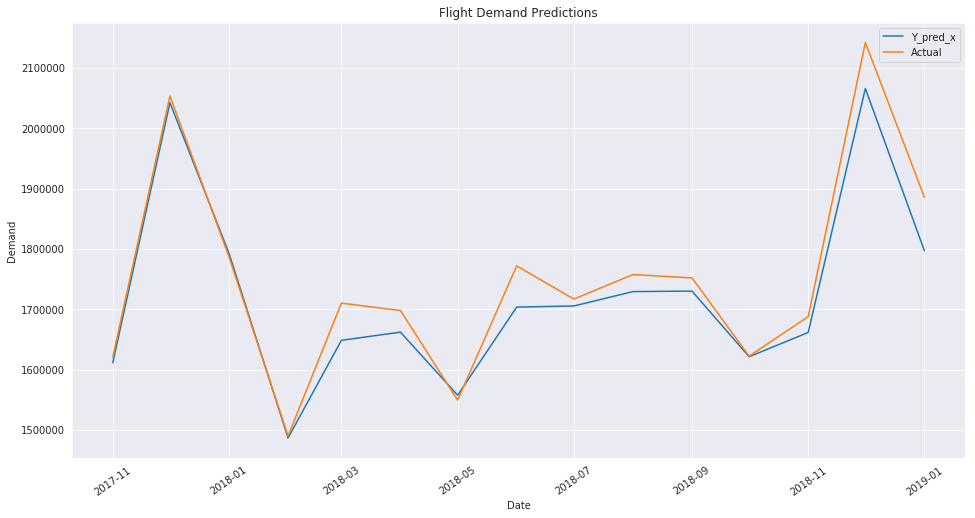

In [39]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,8))
plt.title('Flight Demand Predictions')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot(xg_y_test_gbd.index, xg_y_test_gbd['y_pred'], label='Y_pred_x')
plt.plot(xg_y_test_gbd.index, xg_y_test_gbd['passengers_out'], label='Actual')
plt.xticks(rotation=35)
plt.legend()
plt.show()

In [40]:
print('Test RMSE: ',((xg_y_test_gbd['y_pred'] - xg_y_test_gbd['passengers_out']) ** 2).mean() ** .5)

Test RMSE:  41504.86681597061


In [41]:
eli5.explain_weights_xgboost(xg)

Weight,Feature
0.1198,foreignport_Auckland
0.1179,foreignport_Los Angeles
0.1148,foreignport_Singapore
0.0558,foreignport_Hong Kong
0.0500,foreignport_Dubai
0.0479,foreignport_Bangkok
0.0390,foreignport_Kuala Lumpur
0.0377,foreignport_Tokyo
0.0291,australianport_Sydney
0.0290,foreignport_Christchurch


In [42]:
sept_dec = X_train.loc[(X_train['month'] > 8) & (X_train['year'] == 2016)]
sept_dec['year'] = 2018
xg_preds = xg.predict(sept_dec)
rf_preds = rfr.predict(sept_dec)
sept_dec['xg_pred'] = xg_preds
sept_dec['rf_pred'] = rf_preds

/home/srooney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/srooney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/srooney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [43]:
def get_route(origin, destination, df):
    return df[['year', 'month', 'xg_pred', 'rf_pred']].loc[(df[f'australianport_{origin}'] == 1) & (df[f'foreignport_{destination}'] == 1)]

syd_sing = get_route('Sydney', 'Singapore', sept_dec)
syd_sing

,year,month,xg_pred,rf_pred
73609,2018,9,60965.074219,62820.333333
73777,2018,10,58076.828125,55020.333333
73945,2018,11,59825.484375,57361.000000
74120,2018,12,68379.890625,74285.500000


/home/srooney/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


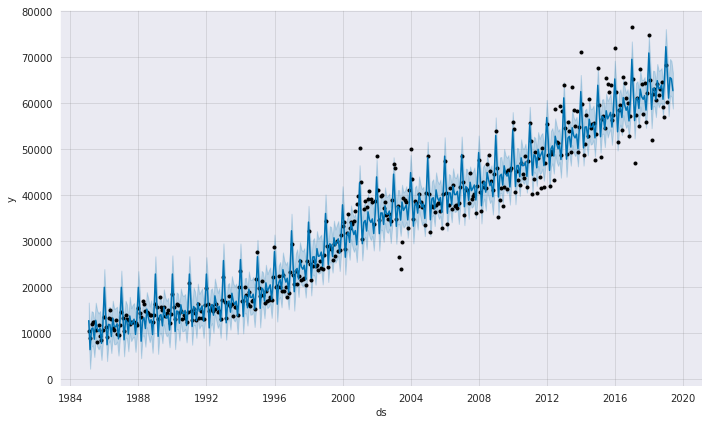

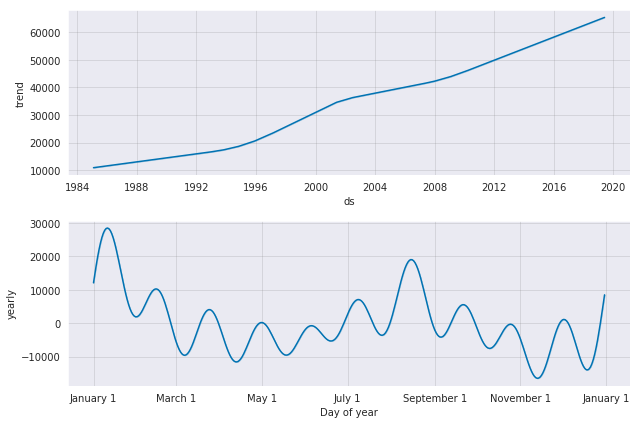

In [44]:
data = by_month[['year_month','Sydney_Singapore']]
data.head()

data.columns = ['ds', 'y']
data.head()

model = Prophet()
model.fit(data)
future_data = model.make_future_dataframe(periods=4, freq = 'm')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
model.plot(forecast_data);
model.plot_components(forecast_data);

In [45]:
fd = forecast_data[['ds', 'yhat']].loc[(forecast_data['ds'] > dt.datetime.strptime('2018-08-31', '%Y-%m-%d'))]

new_data = pd.read_csv('./data/city_pairs_new.csv')
new = new_data['Passengers_Out'].loc[(new_data['Month_num'].isin([9,10,11,12])) & (new_data['Year'] == 2018) & (new_data['AustralianPort'] == 'Sydney') & (new_data['ForeignPort'] == 'Singapore')]
new

77902    64656
78091    59267
78280    57003
78464    68311
Name: Passengers_Out, dtype: int64

In [46]:
fd['xgboost'] = list(syd_sing['xg_pred'])
fd['rf'] = list(syd_sing['rf_pred'])
fd['obsv'] = list(new) + [None]*(len(list(syd_sing['rf_pred'])) - len(list(new)))
fd.head()

ValueError: Length of values does not match length of index

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(16,8))
plt.title('Flight Demand Predictions')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.plot(fd.ds, fd.yhat, label='prophet')
plt.plot(fd.ds, fd.xgboost, label='xg')
plt.plot(fd.ds, fd.rf, label='rf')
plt.plot(fd.ds, fd.obsv, label='obsv')
plt.xticks(rotation=35)
plt.legend()
plt.show()